In [2]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from scipy.io import mmread, mmwrite
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
# from scipy import sparse
import plotly.express as px
from scipy import sparse
import png
import math
import scipy.linalg as LA
import nodevectors
from sklearn.decomposition import PCA
import seaborn as sns
from tabulate import tabulate

In [3]:
# data that maps LAD to region, but isn't ordered the way to LADxLAD matrices are
LAD_Region_lookup = pd.read_csv("LAD_Region_lookup_UK.csv")
regions = LAD_Region_lookup.RGN11NM.unique()
# remove last item of Northern Ireland
regions = regions[:-1]

In [4]:
LAD_Region_lookup = pd.read_csv("LAD_Region_lookup_UK.csv")

In [5]:
n = 380

In [6]:
# only GB
LAD_Region_lookup = LAD_Region_lookup[0:n][['LAD11CD', 'RGN11NM', 'RGN11CD', 'LAD11NM']]

In [7]:
# repeat the dataframe 6 times by row concat
LAD_Region_lookup = pd.concat([LAD_Region_lookup]*6, ignore_index=True)

In [8]:
df = pd.read_csv("YhatProcrusted_allYears.csv")

In [9]:
# rename columns
colnames = ["Longitude", "Latitude", "Number of Active Enterprises", "Everything Else"]
df.columns = colnames

In [10]:
df = pd.concat([df, LAD_Region_lookup], axis=1)

In [11]:
df["NorthIndicator"] = np.where( (df["RGN11NM"] == "South West") | (df["RGN11NM"] == "London") | (df["RGN11NM"] == "South East") | (df["RGN11NM"] == "East of England"), 0, 1) 

In [12]:
year_list = [2005, 2006, 2007, 2008, 2009, 2010]

# repeat each item  in yearlist n times and add as a column
df["Year"] = np.repeat(year_list, n)

In [13]:
df['NorthorSouth'] = np.where(df['NorthIndicator'] >0, 'North', 'South')

In [14]:
# how many LADs in the North and South 
nN = df[(df['NorthorSouth'] == 'North') & (df['Year'] == 2005)].shape[0]
nS = df[(df['NorthorSouth'] == 'South') & (df['Year'] == 2005)].shape[0]
[nN, nS]

[196, 184]

In [15]:
df

,Longitude,Latitude,Number of Active Enterprises,Everything Else,LAD11CD,RGN11NM,RGN11CD,LAD11NM,NorthIndicator,Year,NorthorSouth
0,539053.484028,226612.218162,-53010.766233,78483.839745,E07000100,East of England,E12000006,St Albans,0,2005,South
1,487576.465197,316318.666346,-25666.573446,-87394.790272,E07000104,East of England,E12000006,Welwyn Hatfield,0,2005,South
2,675382.142763,303537.368693,10669.202601,-15742.320586,E07000098,East of England,E12000006,Hertsmere,0,2005,South
3,390444.473176,184429.050495,13192.010887,-13897.635760,E07000096,East of England,E12000006,Dacorum,0,2005,South
4,467847.301120,269215.784743,129782.178992,131758.500508,E06000056,East of England,E12000006,Central Bedfordshire,0,2005,South
...,...,...,...,...,...,...,...,...,...,...,...
2275,381957.633476,471868.821971,-42930.067383,-95209.382119,S12000028,Scotland,S92000003,South Ayrshire,1,2010,North
2276,369485.215905,379989.585127,-58284.011597,-134158.682360,S12000029,Scotland,S92000003,South Lanarkshire,1,2010,North
2277,426139.233289,399187.154363,-66240.144657,-138094.798539,S12000030,Scotland,S92000003,Stirling,1,2010,North
2278,399571.418435,406146.773506,-28546.532439,-106887.168419,S12000039,Scotland,S92000003,West Dunbartonshire,1,2010,North


In [16]:
yearOnYear = []

for year in range(2005,2011):
    data = df[df['Year'] == year]
    dataN = data[data['NorthIndicator']==0]
    dataS = data[data['NorthIndicator']==1]
    avgN = [np.mean(dataN['Longitude']), np.std(dataN['Longitude']), np.mean(dataN['Latitude']),  np.std(dataN['Latitude']),
            np.mean(dataN['Number of Active Enterprises']), np.std(dataN['Number of Active Enterprises']), np.mean(dataN['Everything Else']), np.std(dataN['Everything Else']), 
            "North" , year]
    avgS = [np.mean(dataS['Longitude']), np.std(dataS['Longitude']), np.mean(dataS['Latitude']),  np.std(dataS['Latitude']),
            np.mean(dataS['Number of Active Enterprises']), np.std(dataS['Number of Active Enterprises']), np.mean(dataS['Everything Else']), np.std(dataS['Everything Else']), 
            "South" , year]
    
    yearOnYear.append(avgN)
    yearOnYear.append(avgS)

yearOnYear = pd.DataFrame(yearOnYear, columns=["Longitude", "stdLongitude", "Latitude", "stdLatitude", "Number of Active Enterprises", "stdNumber of Active Enterprises", "Everything Else", "stdEverything Else", 'NorS', 'Year'])

In [17]:
yearOnYear

,Longitude,stdLongitude,Latitude,stdLatitude,Number of Active Enterprises,stdNumber of Active Enterprises,Everything Else,stdEverything Else,NorS,Year
0,452916.793936,113985.391405,254876.055987,75262.873252,10157.358578,103453.722495,74242.811108,211403.951461,North,2005
1,417872.419743,96335.242946,351617.659579,80583.962119,-3218.348284,106411.579384,37279.547019,213366.048890,South,2005
2,463336.378011,85740.930134,272621.372450,57172.006728,21855.259968,76651.662831,-24386.605986,124256.156960,North,2006
3,430288.241687,81284.469351,354781.320530,80685.008386,132.959584,74697.289432,-41561.425114,110247.494575,South,2006
4,453491.194893,102855.222760,257201.698402,66086.560136,25480.709510,80582.420600,-6987.837823,120001.728587,North,2007
5,431708.781345,72599.239785,355890.961334,73888.744689,13283.677393,71398.731926,-41123.488135,96917.044227,South,2007
6,436708.812176,136347.610539,208653.318711,87638.525468,34056.570698,94666.559935,95607.834675,178192.079918,North,2008
7,403020.100960,96699.359234,353654.230760,106768.555088,23248.710054,76857.828775,38398.517877,155589.953282,South,2008
8,456745.368624,82640.615466,281885.040547,51944.969673,-12091.604633,70537.344362,-68246.240501,88709.785541,North,2009
9,438217.452782,58250.287688,356858.267381,77321.397978,-41436.483840,58371.338070,-82071.045116,80055.374787,South,2009


/tmp/ipykernel_17965/333901244.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(2004,2011)), fontsize=16)
/tmp/ipykernel_17965/333901244.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(2004,2011)), fontsize=16)
/tmp/ipykernel_17965/333901244.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(2004,2011)), fontsize=16)
/tmp/ipykernel_17965/333901244.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(2004,2011)), fontsize=16)


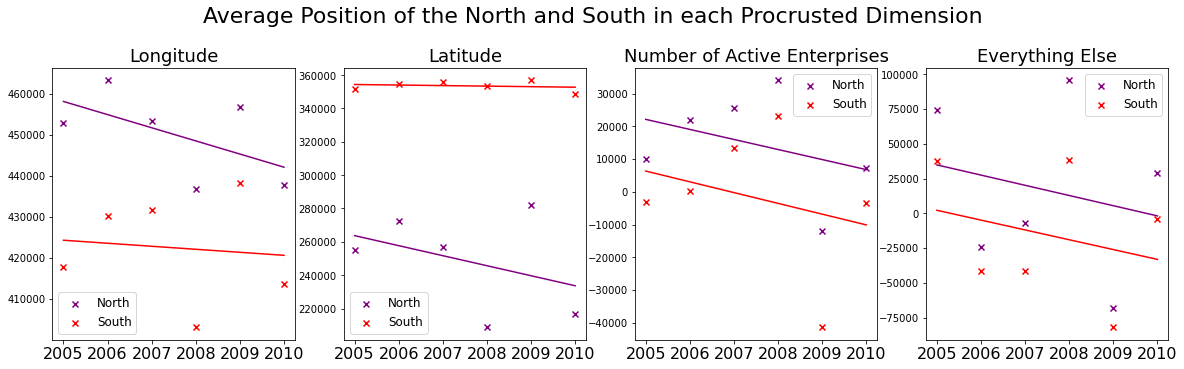

In [39]:
fig, axes = plt.subplots(1,4, figsize=(20,5))

for i, ax in enumerate(axes):
    ax.set_title(colnames[i], fontsize=18)
    ax.set_xticks=(list(range(0,6)))
    ax.set_xticklabels(list(range(2004,2011)), fontsize=16)
    N = list(yearOnYear[colnames[i]][yearOnYear['NorS']=='North'])
    S = list(yearOnYear[colnames[i]][yearOnYear['NorS']=='South'])
    years = range(2005,2011)

    ax.scatter(years, N, color="purple", label='North', marker='x') #plot North points
    a, b = np.polyfit(years, N, 1) # fit line of best fit
    ax.plot(years, a*years+b, color="purple") # add LoB to plot

    ax.scatter(years, S, color="red", label='South', marker='x')
    a, b = np.polyfit(years, S, 1)
    ax.plot(years, a*years+b, color="red") 
    ax.legend(loc="best", fontsize=12)

plt.suptitle("Average Position of the North and South in each Procrusted Dimension", fontsize=22, y=1.05)
    
plt.savefig('AverageValueYearOnYear_NS_perProcrustedDimension_GB_concWins.pdf')


/tmp/ipykernel_17965/4028342804.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(2004,2011)), fontsize=16, rotation=45)
/tmp/ipykernel_17965/4028342804.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(2004,2011)), fontsize=16, rotation=45)
/tmp/ipykernel_17965/4028342804.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(2004,2011)), fontsize=16, rotation=45)
/tmp/ipykernel_17965/4028342804.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(2004,2011)), fontsize=16, rotation=45)


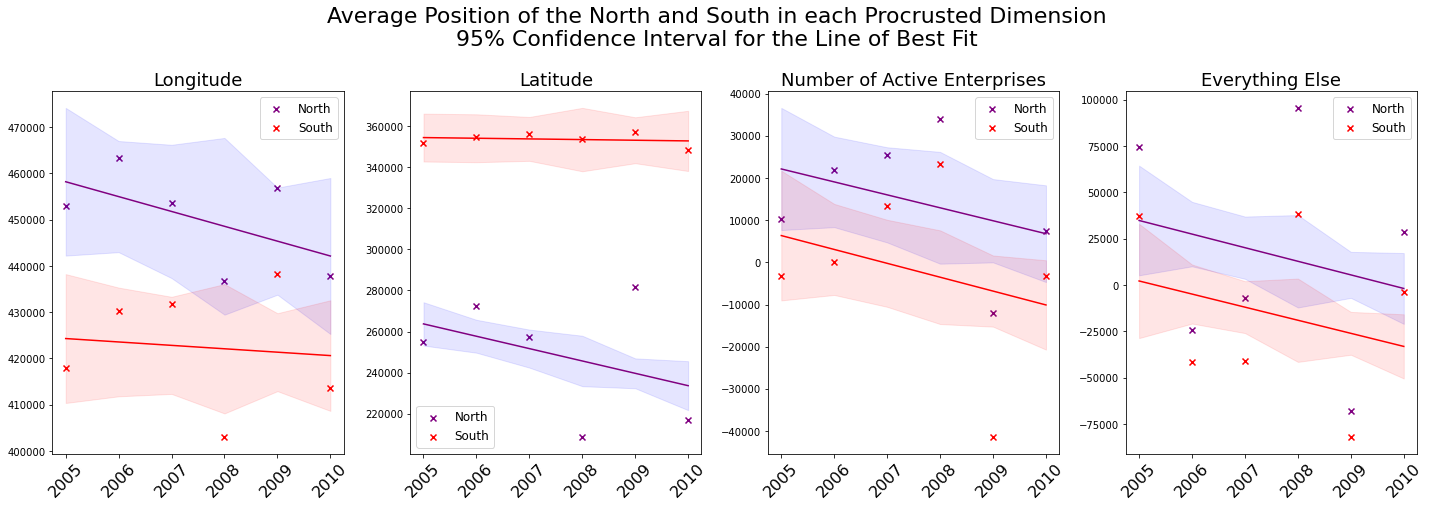

In [46]:
fig, axes = plt.subplots(1,4, figsize=(20,7))

for i, ax in enumerate(axes):
    ax.set_title(colnames[i], fontsize=18)
    ax.set_xticks=(list(range(0,6)))
    ax.set_xticklabels(list(range(2004,2011)), fontsize=16, rotation=45)
    N = list(yearOnYear[colnames[i]][yearOnYear['NorS']=='North'])
    S = list(yearOnYear[colnames[i]][yearOnYear['NorS']=='South'])
    years = range(2005,2011)
    # add a 95% confidence interval
    Nstd = list(yearOnYear['std'+colnames[i]][yearOnYear['NorS']=='North'])
    Sstd = list(yearOnYear['std'+colnames[i]][yearOnYear['NorS']=='South']) 
    Nci = [j * (1.96/np.sqrt(nN)) for j in Nstd]
    Sci = [j * (1.96/np.sqrt(nS)) for j in Sstd]

    ax.scatter(years, N, color="purple", label='North', marker='x') #plot North points
    a, b = np.polyfit(years, N, 1) # fit line of best fit
    ax.plot(years, a*years+b, color="purple") # add LoB to plot
    ax.fill_between(years, (a*years+b-Nci), (a*years+b+Nci), color='b', alpha=.1)

    ax.scatter(years, S, color="red", label='South', marker='x')
    a, b = np.polyfit(years, S, 1)
    ax.plot(years, a*years+b, color="red") 
    ax.fill_between(years, (a*years+b-Sci), (a*years+b+Sci), color='r', alpha=.1)

    ax.legend(loc="best", fontsize=12)
plt.suptitle("Average Position of the North and South in each Procrusted Dimension\n95% Confidence Interval for the Line of Best Fit", fontsize=22, y=1)
plt.tight_layout()    
# plt.savefig('AverageValueYearOnYear_NS_perProcrustedDimension_GB_concWins.pdf')
plt.savefig('AverageValueYearOnYear_NS_perProcrustedDimension_95CI_GB_concWins.pdf')